In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
class GPCControlador:
    def __init__(self, A, B, H, p1, p2, Q, R, m):
        self.A = A
        self.B = B
        self.H = H
        self.p1 = p1
        self.p2 = p2
        self.Q = Q
        self.R = R
        self.m = m
        
        #Calculo de matrices G, F11 y F2
        self.G = self.calculo_G()
        self.F11 = self.calculo_F11()
        self.F2 = self.calculo_F2()
        self.g1 = self.calculo_g1()
    
    def calculo_G(self):
        G = np.zeros((self.p1, self.H.shape[0], self.A.shape[1]))
        for i in range(self.p1):
            G[i] = self.H @ np.linalg.matrix_power(self.A, i+1)
        return G.reshape((self.p1, -1))
    
    def calculo_F11(self):
        F11 = np.zeros((self.p1, self.p2))
        for i in range(self.p1):
            for j in range(min(i+1, self.p2)):
                #Ajuste de la potencia elevada de A
                potencia_A = i - j + (self.p1 - self.p2 - 1)
                F11[i, j] = self.H @ np.linalg.matrix_power(self.A, potencia_A) @ self.B
        return F11
    
    
    def calculo_F2(self):
        F2 = np.zeros((self.p1, self.B.shape[1]))
        for i in range(self.p1):
            sum_A = np.zeros_like(self.A)
            for k in range(i+1):
                sum_A += np.linalg.matrix_power(self.A, k)
            F2[i, :] = (self.H @ sum_A @ self.B).flatten()
        return F2
    
    def calculo_g1(self):
        #Calcular la matriz g1 basada en F11, Q y R
        F11_T_Q = self.F11.T @ self.Q
        g1 = np.linalg.inv(F11_T_Q @ self.F11 + self.R) @ F11_T_Q
        return g1[0:self.m, :]
    
    def calculo_senal_control(self, x_t, u_t_menos_1, Y_d):
        #Calcular la señal de control Δu(t)
        term1 = Y_d - self.G @ x_t - self.F2 @ u_t_menos_1
        DU = self.g1 @ term1
        return DU

In [24]:
#Parámetros proporcionados
Js=0.01 #momento de inercia del rotor
L= 0.5 #inductancia
Rp = 1 #Resistencia
K= 0.01 #Constante de torque
b= 0.1 #constante de friccion viscosa del motor
v0 = 0

In [25]:
#Horizontes
p1 = 5 #Horizonte de predicción
p2 = 3 #Horizonte de control
m = 2 #Como sólo nos interesa el primer movimiento de control

#Valores de las matrices de pesos Q y R.
valor_Q = 9.0
valor_R = 0.5

In [26]:
Q = np.diag([valor_Q] * p1)  #Alto peso en el seguimiento de la referencia.
R = np.diag([valor_R] * p2)  #Peso reducido para permitir el esfuerzo de control.

In [27]:
#Matrices del espacio de estados
A_d = np.array([
    [-b/Js, K/Js],
    [-K/L, -Rp/L]])

B_d = np.array([[0], [1/L]])

H = np.array([[1, 0]])

In [28]:
#DISCRETIZACIÓN MEDIANTE METODO DE EULER
#Tamaño del paso de tiempo
#Delta_t = 0.1  #Ajustar segun la necesidad

Delta_t = 0.16  #Ajustar segun la necesidad

#Matriz identidad del tamaño de A_d
I = np.eye(A_d.shape[0])

#Discretizar A_d y B_d
A = I + Delta_t * A_d
B = Delta_t * B_d

#Condiciones iniciales
x0 = np.array([0, 0])

In [29]:
#Crear una instancia del controlador GPC con los parámetros dados
gpc_controlador = GPCControlador(A, B, H, p1, p2, Q, R, m)

#Número de pasos de simulación
num_muestras = 150

#Inicializar el estado y controlar los vectores de entrada.
x_t = x0.reshape(-1, 1)  #Estado inicial
u_t_menos_1 = np.array([[v0]])  #Entrada de control inicial (tasa de dilución de equilibrio)
Y = []  #Trayectoria de salida
U = []

In [30]:
#Simular el sistema con control GPC
for t in range(num_muestras):
    #Cambia la referencia en los tiempos específicos
    if t < 50:
        Y_d = np.ones((p1, 1)) * 15  
    elif 50 <= t < 100:
        Y_d = np.ones((p1, 1)) * 20 
    else:
        Y_d = np.ones((p1, 1)) * 15  

    #Calcula la señal de control.
    vu_t = gpc_controlador.calculo_senal_control(x_t, u_t_menos_1, Y_d)
    
    #Aplica la señal de control al sistema (solo el primer elemento de ΔU)
    u_t = u_t_menos_1 + vu_t[0, 0]
    
    #Actualiza el estado del sistema
    x_t_plus_1 = A @ x_t + B * u_t
    
    #Calcula la salida
    y_t = H @ x_t
    
    # Almacenar la salida y el control
    Y.append(y_t.item())
    U.append(u_t.item())
    
    #Actualiza variables para la próxima iteración
    x_t = x_t_plus_1
    u_t_menos_1 = np.array([[u_t]]).reshape(1, 1)

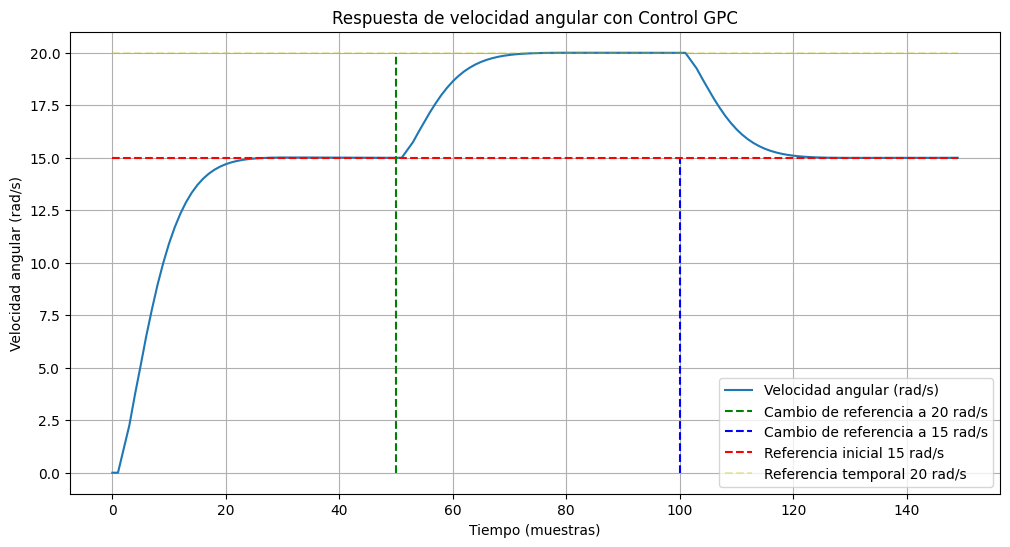

In [31]:
# Gráfico de la velocidad angular
plt.figure(figsize=(12, 6))
plt.plot(range(num_muestras), Y, label='Velocidad angular (rad/s)')
plt.plot([50, 50], [0, 20], 'g--', label='Cambio de referencia a 20 rad/s') 
plt.plot([100, 100], [0, 15], 'b--', label='Cambio de referencia a 15 rad/s') 
plt.plot(range(num_muestras), [15]*num_muestras, 'r--', label='Referencia inicial 15 rad/s')
plt.plot(range(num_muestras), [20]*num_muestras, 'y--', label='Referencia temporal 20 rad/s', alpha=0.3) 
plt.title('Respuesta de velocidad angular con Control GPC')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Velocidad angular (rad/s)')
plt.grid(True)
plt.legend()
plt.show()

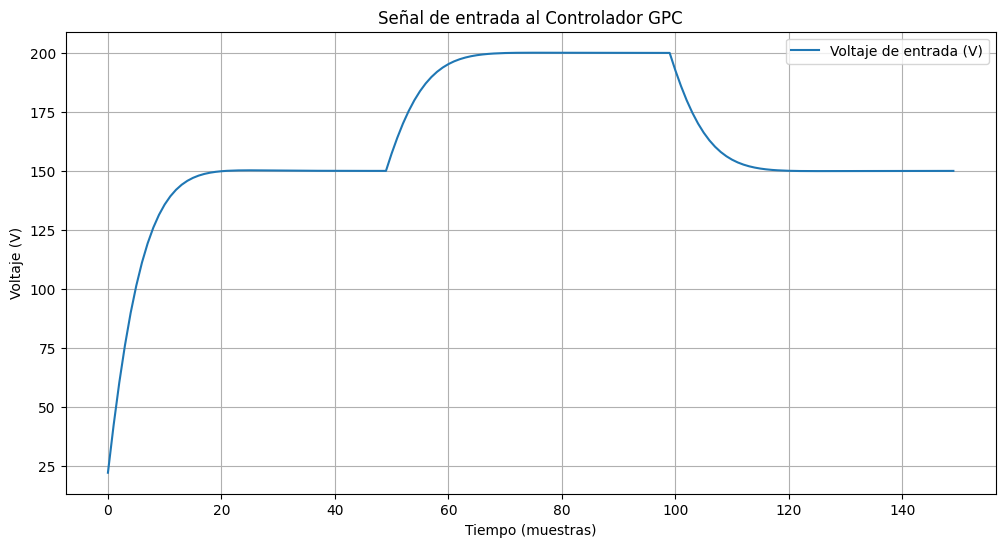

In [32]:
# Gráfico de la señal de entrada (voltaje)
plt.figure(figsize=(12, 6))
plt.plot(range(num_muestras), U, label='Voltaje de entrada (V)')
plt.title('Señal de entrada al Controlador GPC')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Voltaje (V)')
plt.grid(True)
plt.legend()
plt.show()